In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#needed for DNN 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.utils import shuffle

In [3]:
train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/final dataset/test_df.csv')

train = train.drop(['ABSTRACT'], axis=1)
test = test.drop(['ABSTRACT'], axis=1)

In [4]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

print(f'\n Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(f'\n The dataset contains {len(features)} features')


 Train contains 14004 samples and 31 variables

 Test contains 6002 samples and 6 variables

 Number of distinct SUB TOPICS is 25

 The dataset contains 5 features


In [5]:
100 * (train[TOPIC_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Computer Science    42.016567
Physics             27.534990
Statistics          27.092259
Mathematics         20.215653
dtype: float64

In [6]:
train.shape

(14004, 31)

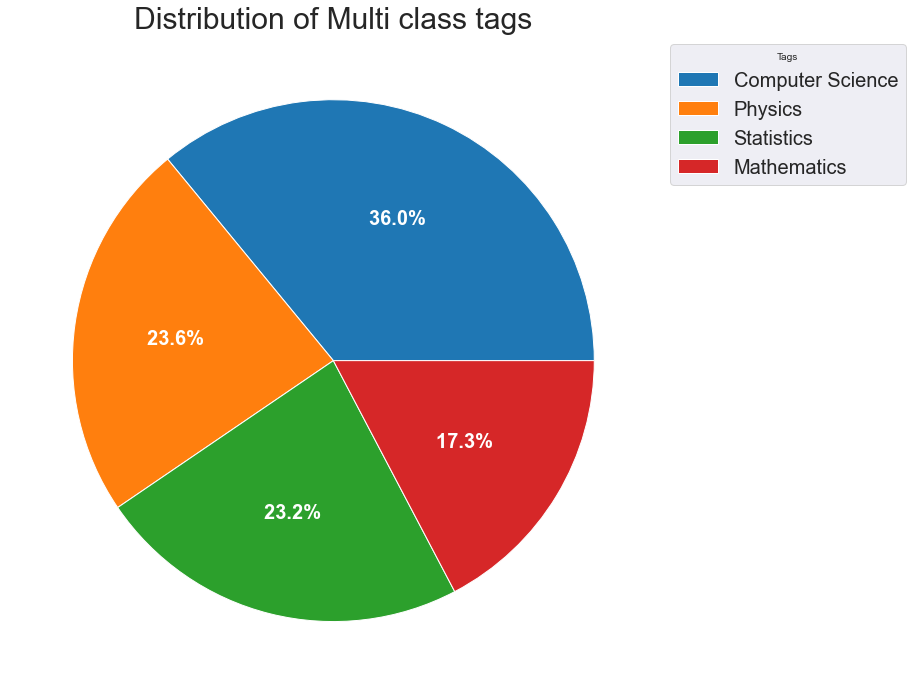

In [7]:
s=100*(train[TOPIC_COLS].sum()/(train.shape[0])).sort_values(ascending=False)
ss=s.to_dict()

labels = []
sizes = []

for x, y in ss.items():
    labels.append(x)
    sizes.append(y)
fig, ax = plt.subplots(figsize=(12,12), subplot_kw=dict(aspect="equal"))

tags = [x for x in labels]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ".format(pct)

# def func(pct, allvals):
#     absolute = int(round(pct/100*np.sum(allvals)))
#     return "{:.1f}%\n({:d} Papers)".format(pct, absolute)


wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))

ax.legend(wedges, tags,
          title="Tags",
          loc=2,
          bbox_to_anchor = (1,1), 
          prop={'size': 20})

plt.setp(autotexts, size=20,weight="bold")

ax.set_title("Distribution of Multi class tags", fontsize=30)

plt.show()

In [8]:
train.head()

,id,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,...,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control,cleaned_text
0,1824,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,evergrowing datasets inside observational astr...
1,3094,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,propose framework consider optimal tmatchings ...
2,8463,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,nanostructures open shell transition metal mol...
3,2082,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,star selfgravitating fluid inside pressure buo...
4,8687,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,deep neural perception control network likely ...


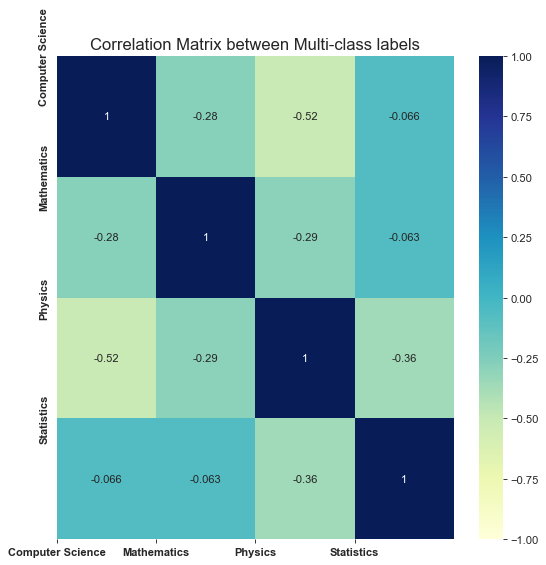

In [9]:
def plotCorrelationMatrix(df, graphWidth):
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = sns.heatmap(corr, vmin=-1, vmax=1,cmap="YlGnBu", annot=True)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=0, weight = 'bold')
    plt.yticks(range(len(corr.columns)), corr.columns, rotation=90, weight = 'bold')
    plt.gca().xaxis.tick_bottom()
    plt.title(f'Correlation Matrix between Multi-class labels', fontsize=15)
    plt.show()

cor_train = train.drop('id', axis =1)
cor_train = cor_train.drop(TARGET_COLS, axis =1)
plotCorrelationMatrix(cor_train, 8)

In [10]:
100 * (test[TOPIC_COLS].sum()/(test.shape[0])).sort_values(ascending=False)

Computer Science    42.135955
Statistics          27.657448
Physics             27.390870
Mathematics         19.893369
dtype: float64

In [11]:
test.head()

,id,Computer Science,Mathematics,Physics,Statistics,cleaned_text
0,9409,0,0,0,1,fundamental frequency f0 approximation polypho...
1,17934,1,0,0,1,largescale study consist 245 million hand hygi...
2,16071,0,0,1,0,present stability analysis plane couette flow ...
3,16870,0,1,0,0,construct finite time blowup solution 2dimensi...
4,10496,0,0,1,0,planetary nebula pne constitute important tool...


In [12]:
multi_class_train_df = train.drop(TARGET_COLS, axis =1)
multi_class_train_df = multi_class_train_df.drop(ID_COL, axis =1)
multi_class_test_df = test.drop(['id'], axis =1)
df = multi_class_train_df.append(multi_class_test_df)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.columns)
df.head()

Index(['Computer Science', 'Mathematics', 'Physics', 'Statistics',
       'cleaned_text'],
      dtype='object')


,Computer Science,Mathematics,Physics,Statistics,cleaned_text
0,0,0,1,0,low radio frequency survey important consider ...
1,0,0,1,0,highmass star generally assume accrete mass al...
2,0,1,0,0,algorithm consider solve smooth nonconvex opti...
3,1,0,1,0,smart active particle acquire limited knowledg...
4,1,0,0,0,consider fundamental problem construct fast ci...


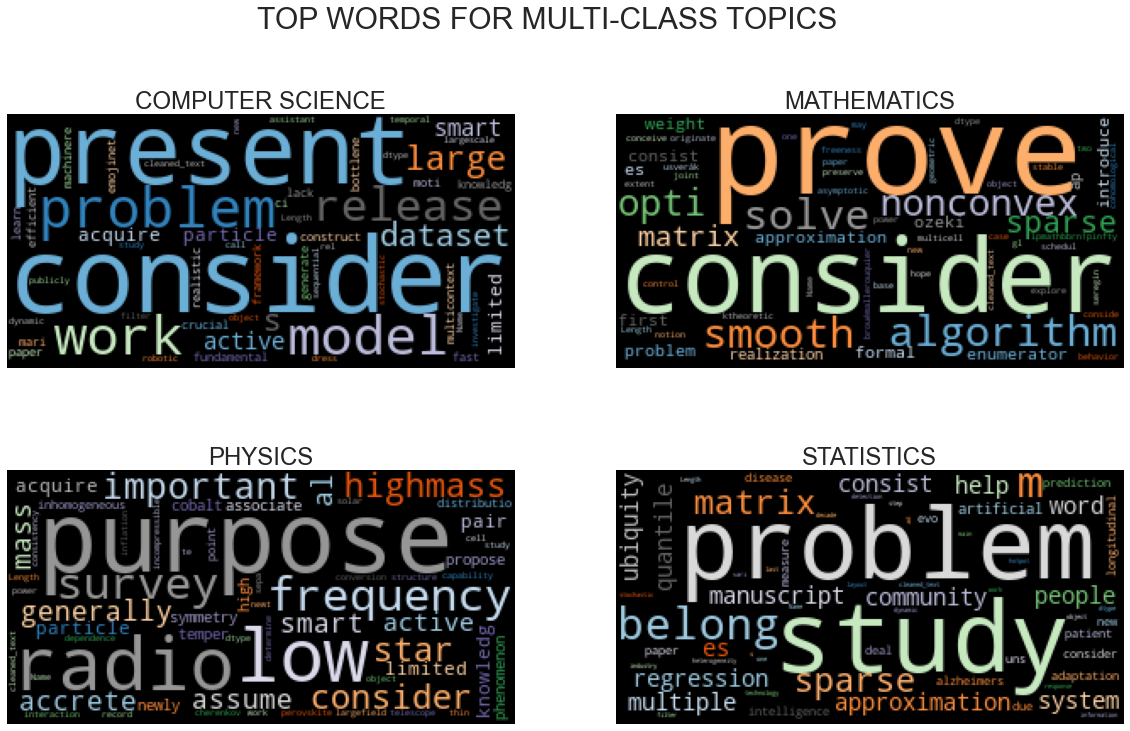

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42,width=300, height=150, max_words=100,colormap='tab20c',collocations=True)
for i, sub_topic_name in enumerate(['Computer Science', 'Mathematics', 'Physics', 'Statistics']):
  sub_topic = df[df[sub_topic_name] == 1]
  text = str(sub_topic['cleaned_text'])
  op = wc.generate(text)
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR MULTI-CLASS TOPICS', fontsize=30)

In [14]:
# set aside 20% of train and test data for evaluation
df.cleaned_text=df.cleaned_text.astype(str)

X = df.cleaned_text
Y = df.iloc[:,0:4]

def dataset_split(inputs, tags):

    X,X_test,y,y_test = train_test_split(inputs,tags,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(inputs),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(X,Y)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 20006 
	Training		 16204 
	Test			 2001 
	Validation		 1801


In [15]:
# Train Data Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 200
vocab_size = 50000

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>",filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(X_train.values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Taining Data padding
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding='post', maxlen=max_length)

# Validation Data padding
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding='post', maxlen=max_length)

# testing data padding
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding='post',maxlen=max_length)

Found 70255 unique tokens.


In [16]:
# def word_embedding(train, test, max_features, max_len=200):
#     try:
#         # Keras Tokenizer class object
#         tokenizer = text.Tokenizer(num_words=max_features)
#         tokenizer.fit_on_texts(train)
        
#         train_data = tokenizer.texts_to_sequences(train)
#         test_data = tokenizer.texts_to_sequences(test)
        
#         # Get the max_len
#         vocab_size = len(tokenizer.word_index) + 1
        
#         # Padd the sequence based on the max-length
#         x_train = sequence.pad_sequences(train_data, maxlen=max_len, padding='post')
#         x_test = sequence.pad_sequences(test_data, maxlen=max_len, padding='post')
#         # Return train, test and vocab size
#         return tokenizer, x_train, x_test, vocab_size
#     except ValueError as ve:
#         raise(ValueError("Error in word embedding {}".format(ve)))

In [17]:
def padded_infos(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_infos(X_train[2],train_sequences[2],train_padded[2])


			 Encoded Sequences  

algorithm consider solve smooth nonconvex optimization problem propose inside worstcase take mathcaloepsilon32 iteration drive norm gradient objective function prescribe positive real number epsilon take mathcaloepsilon3 iteration drive leftmost eigenvalue hessian objective epsilon propose algorithm general framework cover wide range technique include quadratically cubically regularize newton method adaptive regularisation help cubics arc method recently propose trustregion algorithm contraction expansion trace generality method achieve introduction generic condition trial step require satisfy inside particular allow consider inexact regularize newton step use condition center around new subproblem approximately solve obtain trial step satisfy condition new instance framework distinct arc trace describe may view hybrid quadratically cubically regularize newton method numerical result demonstrate hybrid algorithm outperforms cublicly regularize newton method 
 

In [18]:
#confusion matrix
def conf_matrix(y_pred):
  # preds = np.where(y_pred < 0.5, 0, 1)
  cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['Computer Science', 'Mathematics', 'Physics', 'Statistics'], 
                       columns = ['Computer Science', 'Mathematics', 'Physics', 'Statistics'])
  sns.set(font_scale=2) 
  plt.figure(figsize=(12,8))
  sns.heatmap(cm_df, annot=True,cmap="OrRd", fmt='g')
  plt.ylabel('True label',fontsize=20)
  plt.xlabel('Predicted label',fontsize=20)
  plt.xticks( rotation=90, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.show()
  plt.close()

In [19]:
accuracy_threshold = 0.999
from tensorflow import keras
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('binary_accuracy') > ACCURACY_THRESHOLD):
      if(logs.get('binary_accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()


In [20]:
embedding_dim=128
num_category = 4
opt=RMSprop(0.001)


In [21]:
def Bidirectional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a Bidirectional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint,reduceLROnPlat ]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(50000, embedding_dim, input_length=train_padded.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [22]:
# Bidirection GRU 
BiGRU_model, BiGRU_history = Bidirectional_classifier_model(model_name = GRU,
                                                            file_name = 'BiGRU.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          198144    
_________________________________________________________________
dense (Dense)                (None, 200, 28)           7196      
_________________________________________________________________
dropout (Dropout)            (None, 200, 28)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 128)          3712      
__________________________________

63/63 [==============================] - 4s 11ms/step - loss: 0.2952 - binary_accuracy: 0.8969
loss 0.29524874687194824
Accuracy 0.8969265222549438
Precision 0.8814990950144902
Recall 0.9299794547170859
f1 score 0.9050905381536584


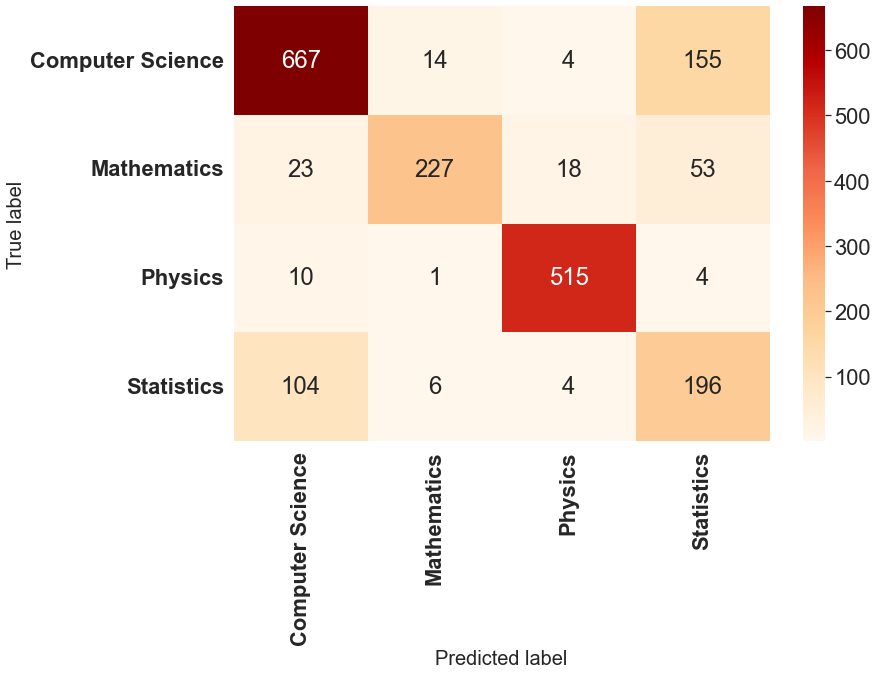

In [23]:
#make predictions

model = load_model("models/BiGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='weighted')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

In [24]:
#Report generation

def report_generate(pred,classifier):
  # Computer Science	Mathematics	Physics	Statistics
  report = pd.DataFrame(classification_report(y_true = y_test.values.argmax(axis=1), y_pred =np.argmax(pred, axis=1), output_dict=True)).transpose()
  report = report.rename(index={'0': 'Computer Science','1':'Mathematics','2':'Physics', '3': 'Statistics'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)

  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  plt.set_title('Multi-class Classification Report for '+str(classifier)+' .', fontsize=20)
  plt.tick_params(axis='x',rotation=30,labelsize=25)
  plt.tick_params(axis='y',rotation=0,labelsize=25)
  plt.legend(['precision', 'recall', 'f1-score'], loc=2,bbox_to_anchor = (1,1), prop={'size': 20})
  plt.grid('white')
  return plt,report

,precision,recall,f1-score
Computer Science,82.96,79.40,81.14
Mathematics,91.53,70.72,79.79
Physics,95.19,97.17,96.17
Statistics,48.04,63.23,54.60
accuracy,80.21,80.21,80.21
macro avg,79.43,77.63,77.93
weighted avg,82.17,80.21,80.79


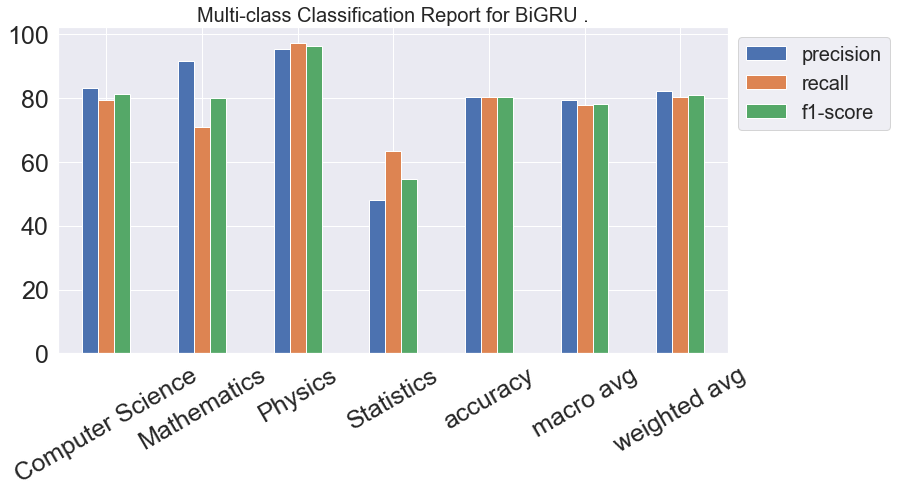

In [25]:
GRUreport=report_generate(predictions,"BiGRU")
GRUreport[1]

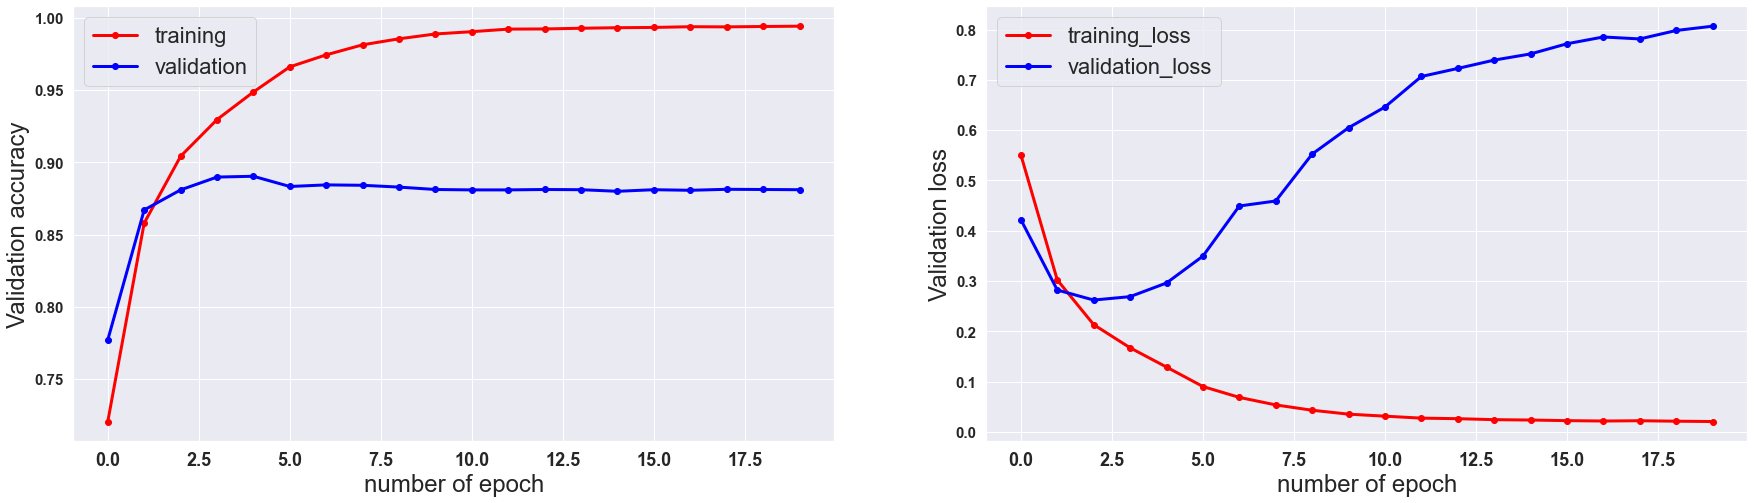

In [26]:
def model_evaluate(history):
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H['binary_accuracy'], label = 'training', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_binary_accuracy'], label = 'validation', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H['loss'], label = 'training_loss', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_loss'], label = 'validation_loss', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
    
model_evaluate(BiGRU_history)

In [27]:
BiLSTM_model, BiLSTM_history = Bidirectional_classifier_model(model_name = LSTM,
                                                            file_name = 'BiLSTM.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          6400000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          263168    
_________________________________________________________________
dense_5 (Dense)              (None, 200, 28)           7196      
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 28)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 200, 128)          3712      
________________________________

63/63 [==============================] - 5s 39ms/step - loss: 0.2799 - binary_accuracy: 0.8963
loss 0.2799268960952759
Accuracy 0.8963018655776978
Precision 0.8835760042356984
Recall 0.9231078904991948
f1 score 0.9029094505604223


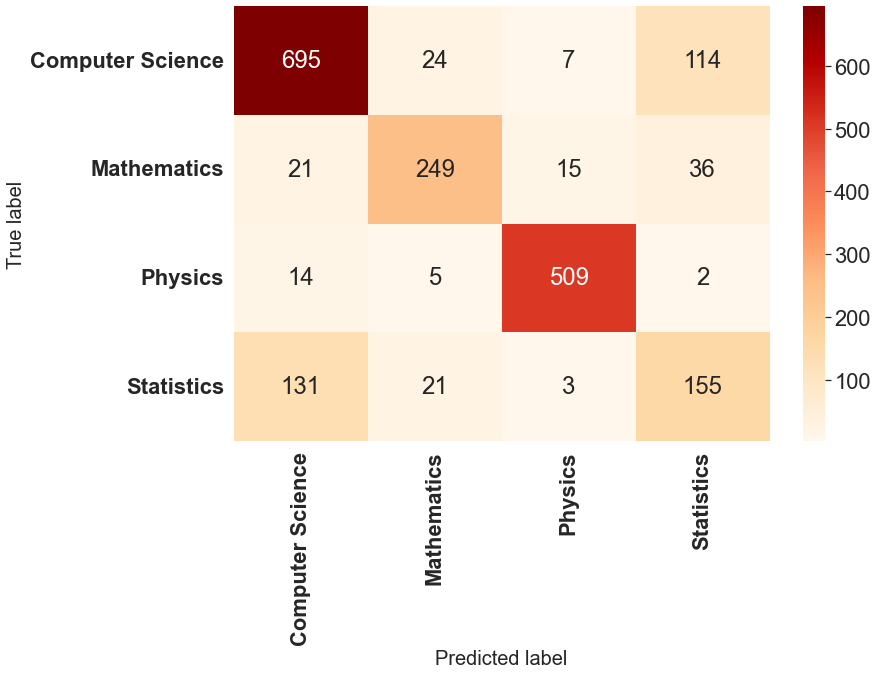

In [28]:
#make predictions


model = load_model("models/BiLSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='weighted')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

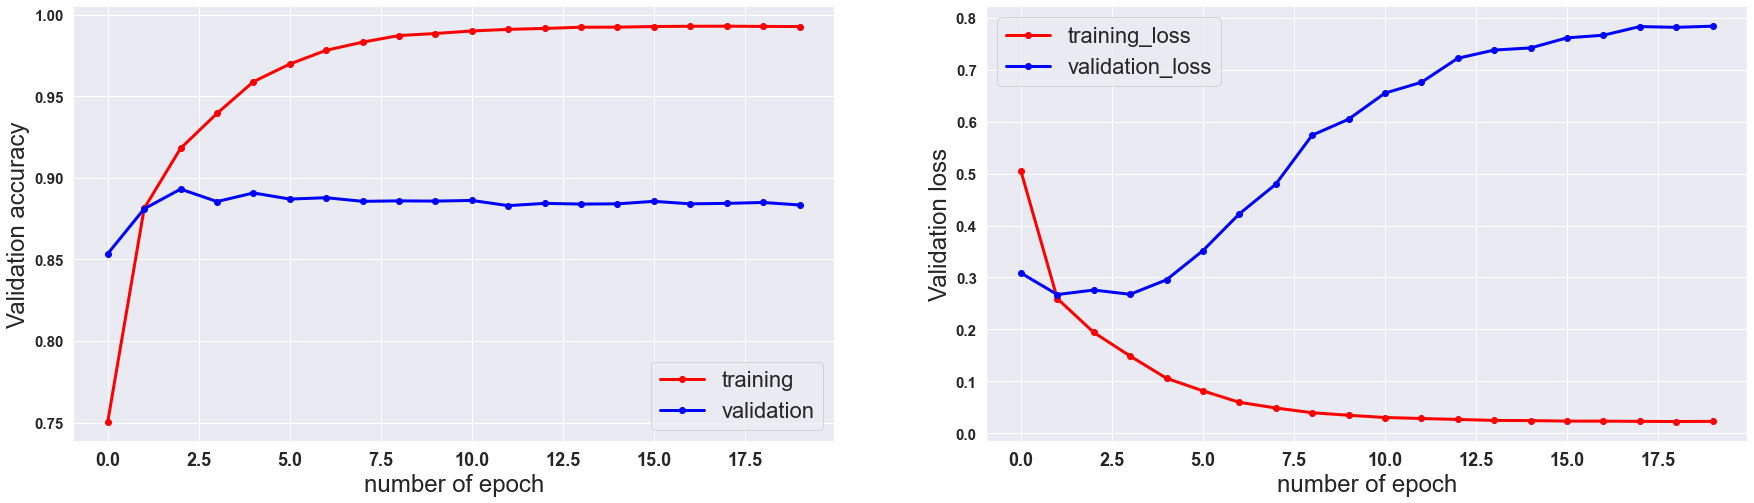

In [29]:
model_evaluate(BiLSTM_history)

In [30]:
def directional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(50000, embedding_dim, input_length=train_padded.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.2),
        model_name(GRU_unit,return_sequences=True),
#         model_name(128, dropout = 0.2),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          6400000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          131584    
_________________________________________________________________
dense_10 (Dense)             (None, 200, 28)           3612      
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 28)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 200, 128)          3712      
________________________________

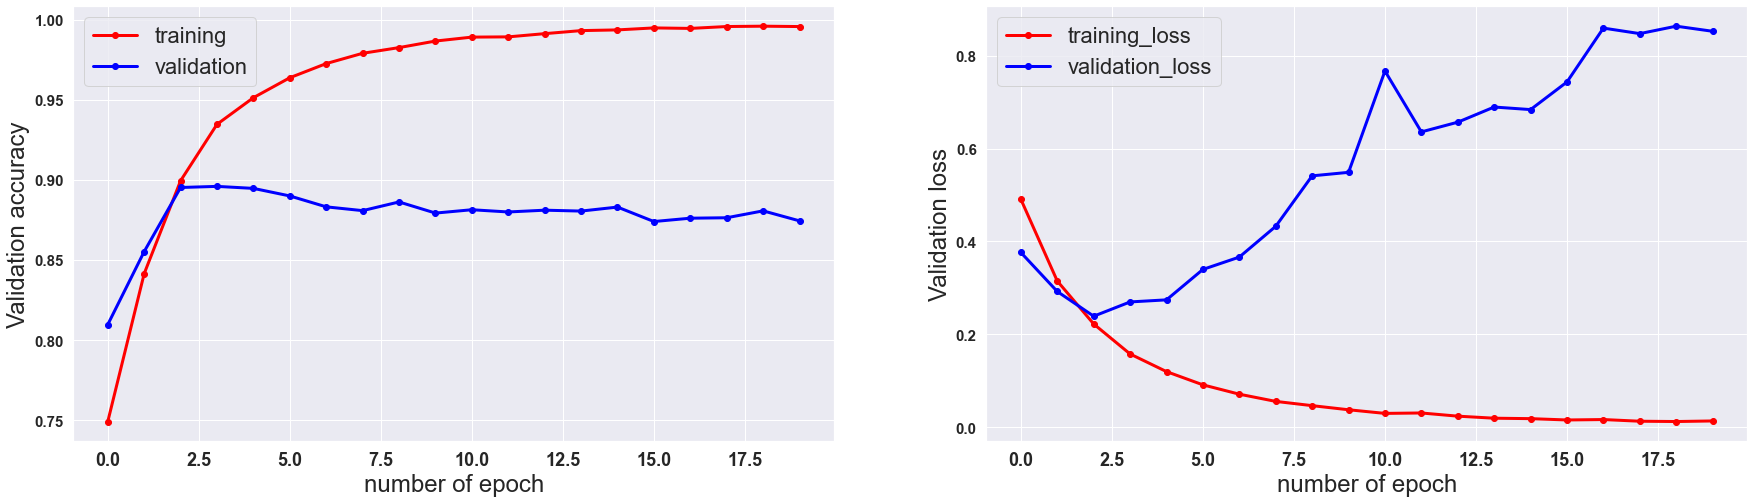

In [31]:
LSTM_model, LSTM_history =directional_classifier_model(model_name = LSTM,
                                                            file_name = 'LSTM.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)
model_evaluate(LSTM_history)

63/63 [==============================] - 2s 9ms/step - loss: 0.2612 - binary_accuracy: 0.8999
loss 0.26119866967201233
Accuracy 0.8999250531196594
Precision 0.9127516530552598
Recall 0.9296462879671276
f1 score 0.9211215093171568


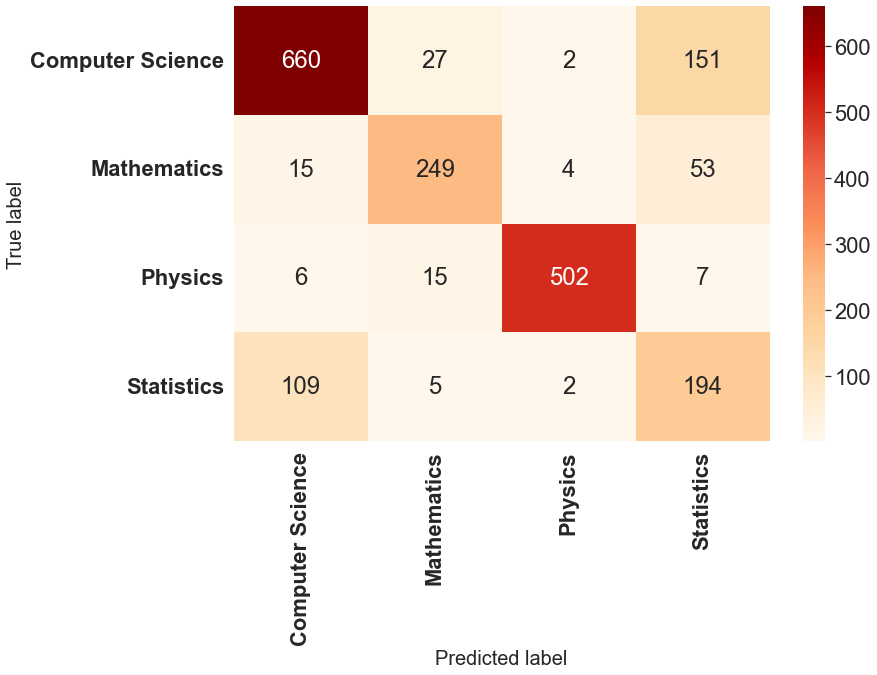

In [32]:
#make predictions


model = load_model("models/LSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='micro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          6400000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 128)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 128)          99072     
_________________________________________________________________
dense_15 (Dense)             (None, 200, 28)           3612      
_________________________________________________________________
dropout_12 (Dropout)         (None, 200, 28)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 200, 128)          3712      
________________________________

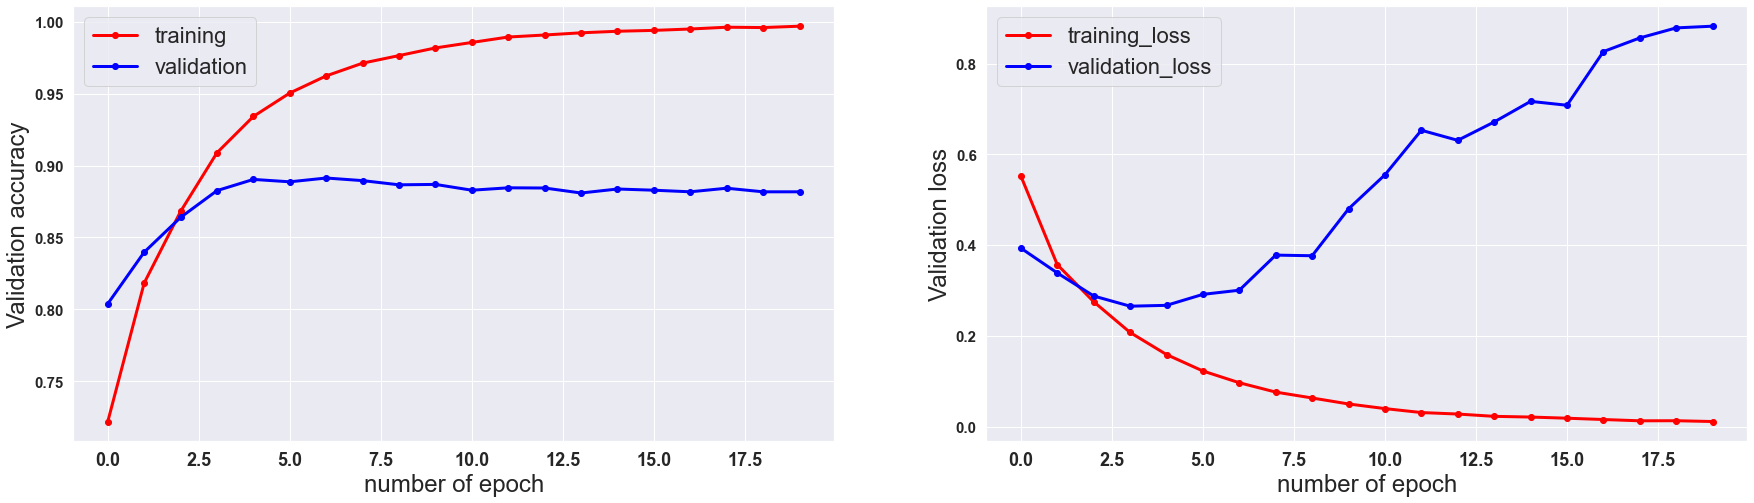

In [33]:
GRU_model, GRU_history =directional_classifier_model(model_name = GRU,
                                                            file_name = 'GRU.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)
model_evaluate(GRU_history)

63/63 [==============================] - 2s 27ms/step - loss: 0.3128 - binary_accuracy: 0.8883
loss 0.31278401613235474
Accuracy 0.8883058428764343
Precision 0.8994621196997538
Recall 0.9159031595313454
f1 score 0.9076081896429087


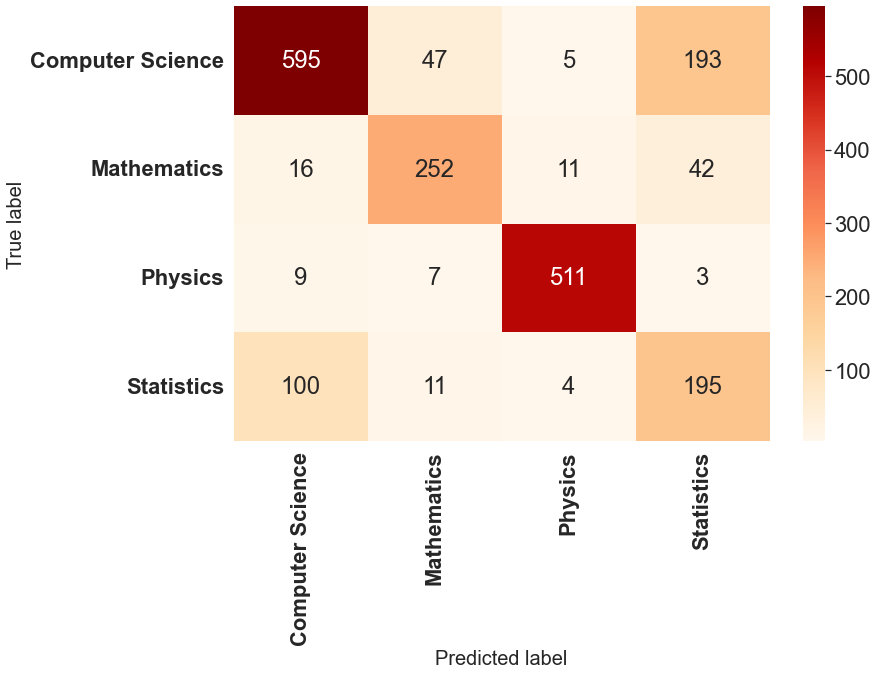

In [34]:
#make predictions


model = load_model("models/GRU.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='micro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

conf_matrix(predictions)

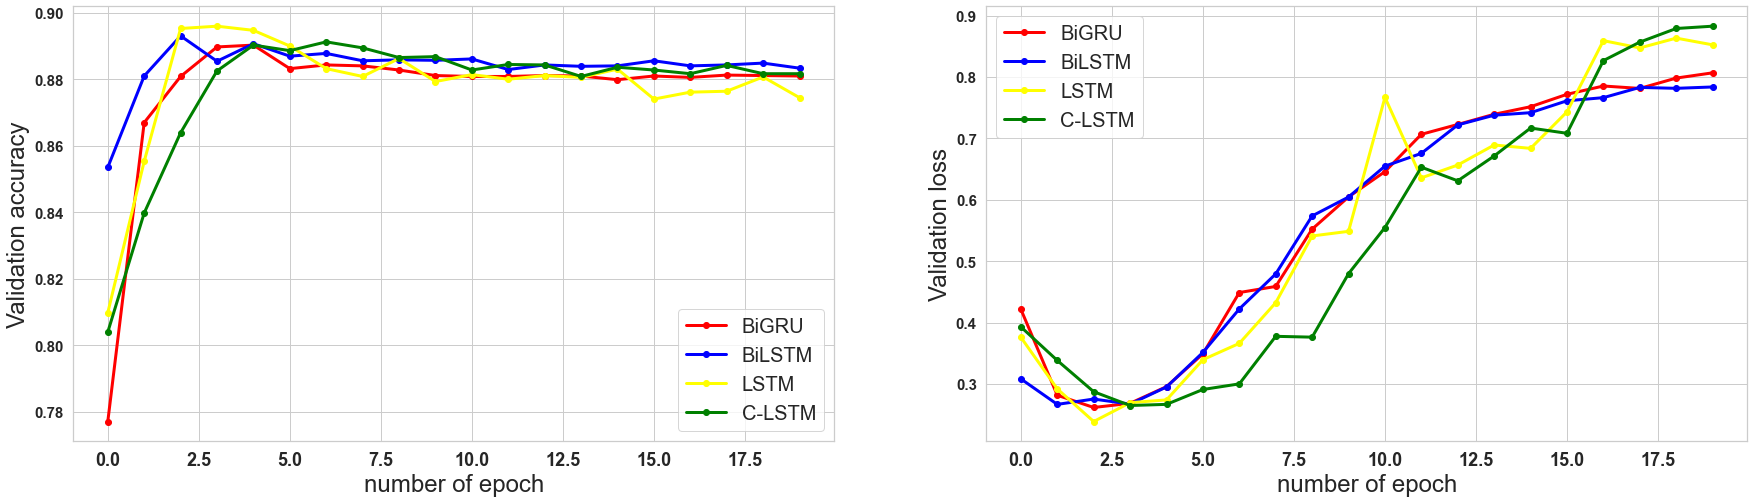

In [38]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_binary_accuracy'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_binary_accuracy'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_binary_accuracy'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_binary_accuracy'], label = 'C-LSTM', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'C-LSTM', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})
model_all_evaluate(BiGRU_history, BiLSTM_history,LSTM_history, GRU_history )

In [40]:
Bigru = load_model("models/BiGRU.h5")
Bilstm = load_model("models/BiLSTM.h5")
lstm = load_model("models/LSTM.h5")
gru = load_model("models/GRU.h5")
MLA = {
     'Bidirectional GRU' : Bigru,
     'Bidirectional LSTM' : Bilstm,
     'LSTM' : lstm,
     'GRU' : gru, 
}

columns = []
compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, y_pred, average='samples')
    weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, y_pred,  average='micro')

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Accuracy'] = evaluation[1]
    compare.loc[row_index, 'loss'] = evaluation[0]
    compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
compare

63/63 [==============================] - 1s 7ms/step - loss: 0.3128 - binary_accuracy: 0.8883


,Name,Accuracy,loss,Precision,Recall,F1 Score
2,LSTM,0.899925,0.261199,0.912752,0.929646,0.921122
0,Bidirectional GRU,0.896927,0.295249,0.904069,0.929979,0.916841
1,Bidirectional LSTM,0.896302,0.279927,0.899413,0.923108,0.911106
3,GRU,0.888306,0.312784,0.899462,0.915903,0.907608
